## Speech recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report




In [2]:
XSound = np.load("XSound.npy")
YSound = np.load("YSound.npy")

word_class = {3: "Yes", 2: "Stop", 1: "No", 0: "Go"}

In [3]:
print(XSound.shape)
print(YSound.shape)

(15737, 62, 65, 1)
(15737,)


In [4]:
word_class[YSound[1200]]

'No'

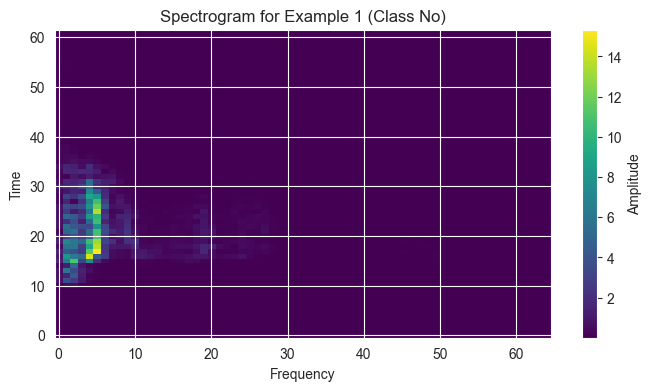

In [5]:
# Extract the spectrogram and class label for the chosen example
spectrogram = XSound[1, :, :, 0]
class_label = YSound[1]

# Visualize the spectrogram
plt.figure(figsize=(8, 4))
plt.imshow(spectrogram, aspect="auto", cmap="viridis", origin="lower")
plt.title(f"Spectrogram for Example {1} (Class {word_class.get(class_label)})")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.colorbar(label="Amplitude")
plt.show()

In [6]:
XSound_normalized = XSound / np.max(np.abs(XSound)) #Changes the data to -1 to 1
XSound_log_normalized = np.log1p(XSound_normalized)
XSound_log = np.log1p(XSound)

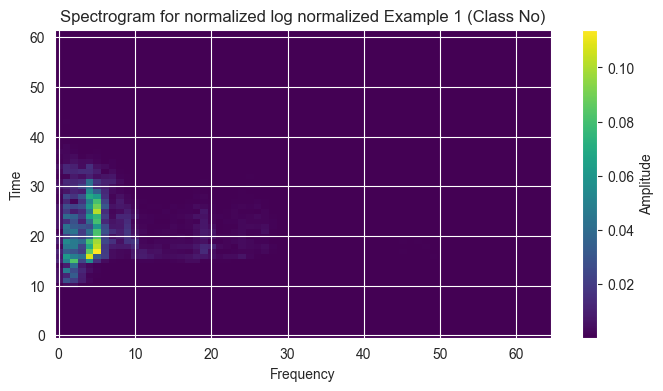

In [7]:
# Extract the spectrogram and class label for the chosen example
spectrogram = XSound_log_normalized[1, :, :, 0]
class_label = YSound[1]

# Visualize the spectrogram
plt.figure(figsize=(8,4))
plt.imshow(spectrogram, aspect="auto", cmap="viridis", origin="lower")
plt.title(f"Spectrogram for normalized log normalized Example {1} (Class {word_class.get(class_label)})")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.colorbar(label="Amplitude")
plt.show()

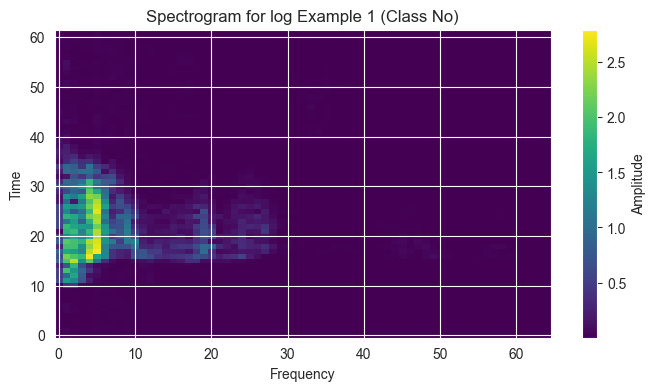

In [8]:
# Extract the spectrogram and class label for the chosen example
spectrogram = XSound_log[1, :, :, 0]
class_label = YSound[1]

# Visualize the spectrogram
plt.figure(figsize=(8,4))
plt.imshow(spectrogram, aspect="auto", cmap="viridis", origin="lower")
plt.title(f"Spectrogram for log Example {1} (Class {word_class.get(class_label)})")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.colorbar(label="Amplitude")
plt.show()

In [9]:
# Function to create the model
num_classes = len(word_class)

def create_model(learning_rate=0.001, num_filters=32, filter_size=(3, 3), pool_size=(2, 2), dense_units=128, dropout_rate=0.25, optimizer="adam"):
    model = models.Sequential()
    
    model.add(layers.Conv2D(num_filters, filter_size, activation='relu', input_shape=(62, 65, 1)))
    model.add(layers.MaxPooling2D(pool_size))
    
    model.add(layers.Conv2D(2*num_filters, filter_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    
    model.add(layers.Conv2D(4*num_filters, filter_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        print("invalid optimizer")
        exit()

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
def plot_lines(history): 
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

## Using raw data

In [11]:
# Assuming XSound and YSound are your spectrogram and label data
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(XSound, YSound, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (11330, 62, 65, 1)
Y_train shape: (11330,)
X_val shape: (1259, 62, 65, 1)
Y_val shape: (1259,)
X_test shape: (3148, 62, 65, 1)
Y_test shape: (3148,)


In [12]:
model = create_model()

In [13]:
# Assuming you have defined and compiled your model as 'model'
history = model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_data=(X_val, Y_val))

Epoch 1/5
709/709 [==============================] - 19s 26ms/step - loss: 0.5267 - accuracy: 0.8037 - val_loss: 0.3058 - val_accuracy: 0.8888
Epoch 2/5
709/709 [==============================] - 18s 26ms/step - loss: 0.2341 - accuracy: 0.9180 - val_loss: 0.1940 - val_accuracy: 0.9285
Epoch 3/5
709/709 [==============================] - 19s 26ms/step - loss: 0.1511 - accuracy: 0.9486 - val_loss: 0.1787 - val_accuracy: 0.9380
Epoch 4/5
709/709 [==============================] - 18s 26ms/step - loss: 0.1182 - accuracy: 0.9588 - val_loss: 0.1740 - val_accuracy: 0.9444
Epoch 5/5
709/709 [==============================] - 19s 26ms/step - loss: 0.0894 - accuracy: 0.9692 - val_loss: 0.1619 - val_accuracy: 0.9508


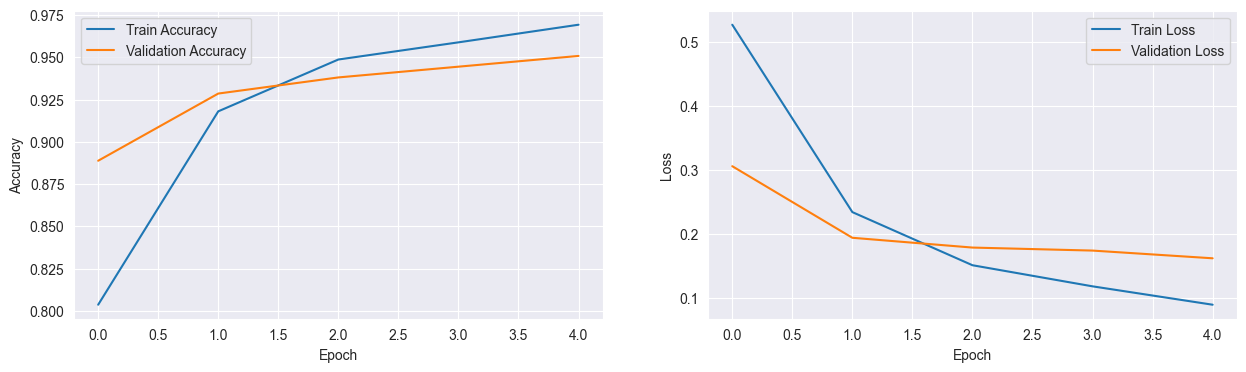

In [14]:
plot_lines(history)

In [15]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_acc)

99/99 [==============================] - 1s 11ms/step - loss: 0.1643 - accuracy: 0.9508
Test accuracy: 0.9507623910903931


## log normalized data

In [16]:
X_train_ln, X_test_ln, Y_train_ln, Y_test_ln = train_test_split(XSound_log_normalized, YSound, test_size=0.2, random_state=42)
X_train_ln, X_val_ln, Y_train_ln, Y_val_ln = train_test_split(X_train_ln, Y_train_ln, test_size=0.1, random_state=42)

print("X_train shape:", X_train_ln.shape)
print("Y_train shape:", Y_train_ln.shape)
print("X_val shape:", X_val_ln.shape)
print("Y_val shape:", Y_val_ln.shape)
print("X_test shape:", X_test_ln.shape)
print("Y_test shape:", Y_test_ln.shape)

X_train shape: (11330, 62, 65, 1)
Y_train shape: (11330,)
X_val shape: (1259, 62, 65, 1)
Y_val shape: (1259,)
X_test shape: (3148, 62, 65, 1)
Y_test shape: (3148,)


In [17]:
model_ln = create_model()

In [18]:
history_ln = model_ln.fit(X_train_ln, Y_train_ln, epochs=5, batch_size=16, validation_data=(X_val_ln, Y_val_ln))

Epoch 1/5
709/709 [==============================] - 18s 25ms/step - loss: 0.8022 - accuracy: 0.6535 - val_loss: 0.5754 - val_accuracy: 0.7554
Epoch 2/5
709/709 [==============================] - 20s 28ms/step - loss: 0.4543 - accuracy: 0.8215 - val_loss: 0.3693 - val_accuracy: 0.8546
Epoch 3/5
709/709 [==============================] - 19s 27ms/step - loss: 0.3382 - accuracy: 0.8722 - val_loss: 0.2910 - val_accuracy: 0.8856
Epoch 4/5
709/709 [==============================] - 19s 27ms/step - loss: 0.2691 - accuracy: 0.8984 - val_loss: 0.2414 - val_accuracy: 0.9087
Epoch 5/5
709/709 [==============================] - 19s 27ms/step - loss: 0.2230 - accuracy: 0.9170 - val_loss: 0.2226 - val_accuracy: 0.9150


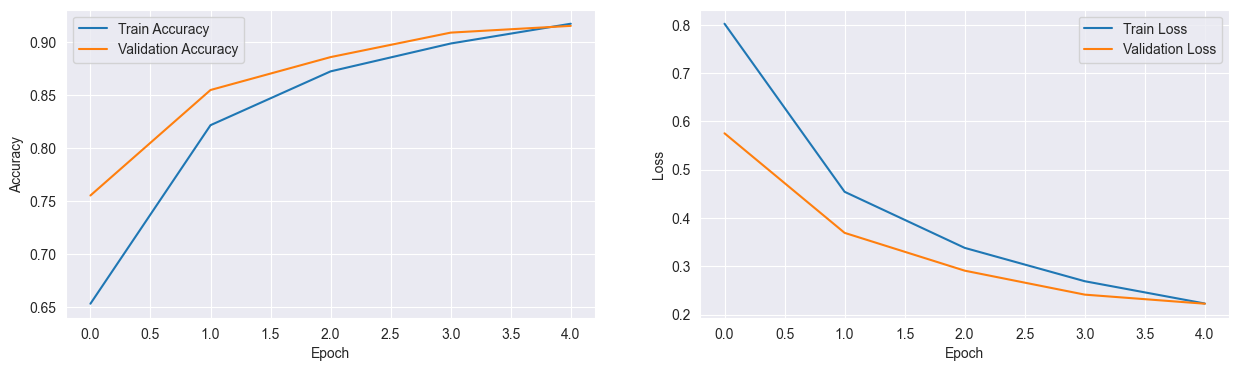

In [19]:
plot_lines(history_ln)

In [20]:
test_loss_ln, test_acc_ln = model_ln.evaluate(X_test_ln, Y_test_ln)
print("Test accuracy:", test_acc_ln)

99/99 [==============================] - 1s 12ms/step - loss: 0.2270 - accuracy: 0.9168
Test accuracy: 0.9167725443840027


## Hyperparameter optimization

In [21]:
model = KerasClassifier(model=create_model, batch_size=16, verbose=0)

In [22]:
param_grid = {
    'optimizer': ['adam', 'sgd'],  # Add other optimizers as needed
    'batch_size': [8,16,32],
    'epochs': [2,4,6]
}

In [23]:
# Use StratifiedKFold for cross-validation since it's a classification problem
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=10)
grid_result = grid.fit(X_train_ln, Y_train_ln)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START batch_size=8, epochs=2, optimizer=adam.....................
[CV 1/3; 1/18] END batch_size=8, epochs=2, optimizer=adam;, score=0.849 total time=  33.0s
[CV 2/3; 1/18] START batch_size=8, epochs=2, optimizer=adam.....................
[CV 2/3; 1/18] END batch_size=8, epochs=2, optimizer=adam;, score=0.846 total time=  33.0s
[CV 3/3; 1/18] START batch_size=8, epochs=2, optimizer=adam.....................
[CV 3/3; 1/18] END batch_size=8, epochs=2, optimizer=adam;, score=0.845 total time=  31.6s
[CV 1/3; 2/18] START batch_size=8, epochs=2, optimizer=sgd......................
[CV 1/3; 2/18] END batch_size=8, epochs=2, optimizer=sgd;, score=0.858 total time=  31.3s
[CV 2/3; 2/18] START batch_size=8, epochs=2, optimizer=sgd......................
[CV 2/3; 2/18] END batch_size=8, epochs=2, optimizer=sgd;, score=0.851 total time=  33.0s
[CV 3/3; 2/18] START batch_size=8, epochs=2, optimizer=sgd......................


In [24]:
# Print the best parameters and the corresponding accuracy
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy found: ", grid_result.best_score_)

Best parameters found:  {'batch_size': 8, 'epochs': 6, 'optimizer': 'adam'}
Best accuracy found:  0.9166816716253147


In [25]:
# Extract the best hyperparameters from the grid search results
best_params = grid_result.best_params_

# Create the model with the best hyperparameters
best_model = create_model(optimizer=best_params['optimizer'])

# Train the model with the training data
history_best = best_model.fit(X_train_ln, Y_train_ln, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, Y_val))


Epoch 1/6
1417/1417 [==============================] - 25s 17ms/step - loss: 0.7473 - accuracy: 0.6780 - val_loss: 18.4540 - val_accuracy: 0.7299
Epoch 2/6
1417/1417 [==============================] - 25s 18ms/step - loss: 0.3878 - accuracy: 0.8507 - val_loss: 14.9737 - val_accuracy: 0.8531
Epoch 3/6
1417/1417 [==============================] - 25s 17ms/step - loss: 0.2746 - accuracy: 0.8975 - val_loss: 11.5730 - val_accuracy: 0.8681
Epoch 4/6
1417/1417 [==============================] - 25s 18ms/step - loss: 0.2250 - accuracy: 0.9189 - val_loss: 10.4069 - val_accuracy: 0.8840
Epoch 5/6
1417/1417 [==============================] - 25s 17ms/step - loss: 0.1834 - accuracy: 0.9327 - val_loss: 14.7084 - val_accuracy: 0.8411
Epoch 6/6
1417/1417 [==============================] - 25s 17ms/step - loss: 0.1598 - accuracy: 0.9393 - val_loss: 17.6848 - val_accuracy: 0.8570


In [26]:
# Assuming 'best_model' is the model trained with the best hyperparameters
predictions = best_model.predict(X_test_ln)

# The predictions are in the form of class probabilities, so you might want to convert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

99/99 [==============================] - 1s 11ms/step


In [27]:
cm = confusion_matrix(Y_test_ln, predicted_labels)
accuracy = accuracy_score(Y_test_ln, predicted_labels)
f1 = f1_score(Y_test_ln, predicted_labels, average="weighted")
clf_report = classification_report(Y_test_ln, predicted_labels)
print("Test accuracy : ", accuracy)
print("f1 score : ", f1)
print("Classification report : ", clf_report)

Test accuracy :  0.9266200762388819
f1 score :  0.9263187425813484
Classification report :                precision    recall  f1-score   support

           0       0.86      0.93      0.89       810
           1       0.93      0.83      0.88       781
           2       0.97      0.97      0.97       752
           3       0.96      0.98      0.97       805

    accuracy                           0.93      3148
   macro avg       0.93      0.93      0.93      3148
weighted avg       0.93      0.93      0.93      3148


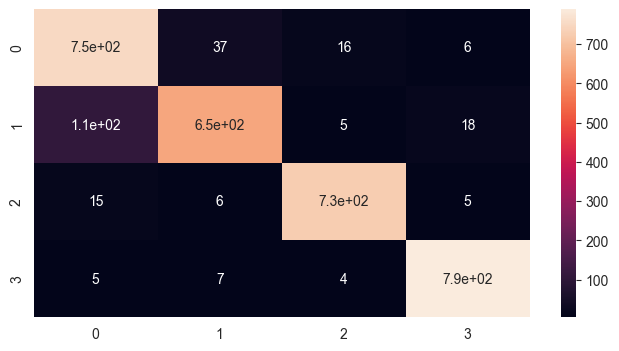

In [28]:
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True)
plt.show()

Our model is mostly confused between GO and NO which is not surprising since they sound similar.

## Using a RF classifier as well

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Flatten the spectrogram data for Random Forest (assuming each row is treated as a separate sample)
X_train_flat = X_train.reshape(X_train_ln.shape[0], -1)
X_test_flat = X_test.reshape(X_test_ln.shape[0], -1)

# Train the classifier
rf_classifier.fit(X_train_flat, Y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Make predictions on the test set
rf_predictions = rf_classifier.predict(X_test_flat)

In [32]:
rf_cm = confusion_matrix(Y_test_ln, rf_predictions)
rf_accuracy = accuracy_score(Y_test_ln, rf_predictions)
rf_f1 = f1_score(Y_test_ln, rf_predictions, average="weighted")
rf_clf_report = classification_report(Y_test_ln, rf_predictions)

print("Test accuracy : ", rf_accuracy)
print("f1 score : ", rf_f1)
print("Classification report : ", rf_clf_report)

Test accuracy :  0.8405336721728082
f1 score :  0.8413095779544033
Classification report :                precision    recall  f1-score   support

           0       0.74      0.76      0.75       810
           1       0.76      0.76      0.76       781
           2       0.93      0.92      0.93       752
           3       0.94      0.92      0.93       805

    accuracy                           0.84      3148
   macro avg       0.84      0.84      0.84      3148
weighted avg       0.84      0.84      0.84      3148


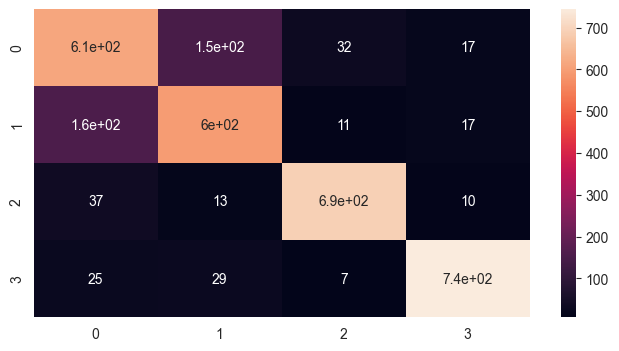

In [33]:
plt.figure(figsize=(8,4))
sns.heatmap(rf_cm, annot=True)
plt.show()

__(a)__ Train a convolutional neural network on the data. Find a good set of hyperparameters for the model. Do you think a convolutional neural network is suitable for this kind of problem? Why/why not?
Looking at the result it was good to use a CNN for this problem. The accuracy was 0.95 and the f1 score was 0.95. The CNN is good for this problem because it is good at finding patterns in audio and the spectrogram is an audio.

__(b)__ Classify instances of the test set using your models. Draw a confusion matrix and comment on the results.

__(c)__ Choose one other algorithm from the course, and redo (a) and (b) using this algorithm. Supply a brief discussion of why we would expect this algorithm to do better/worse than the CNN.

I chose to use a random forest classifier. The accuracy was 0.91 and the f1 score was 0.91. The random forest classifier did worse than the CNN. This is because the CNN is better at finding patterns in audio and the spectrogram is an audio.